In [2]:
import gnssmapper as gm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import interpolate

In [3]:
names=['ucl','goodchild','hermitage']
heights=[46,47,34]
samples_list=[pd.read_csv('../data/'+name+'_exact_samples.csv',index_col=0) for name in names]
for s,n,h in zip(samples_list,names,heights):
    s['location']=n
    s['height']=h

samples = pd.concat(samples_list,axis=0)


In [4]:
samples.describe()


I_1           I_2           I_4            I_8           I_16  \
count  20300.000000  20300.000000  20300.000000   20300.000000   20300.000000   
mean     760.437980   1823.718128   3630.604778    6201.889704    8029.590640   
std     1815.738289   4356.825412   8712.913390   15311.604442   19066.387794   
min        0.000000      0.000000      0.000000       0.000000       0.000000   
25%        4.000000     11.000000     24.000000      32.000000      64.000000   
50%       47.000000    122.000000    256.000000     447.000000     512.000000   
75%      488.000000   1189.000000   2361.250000    4096.000000    4096.000000   
max    11147.000000  29920.000000  68015.000000  131072.000000  131072.000000   

               I_inf         W_100        W_1000       W_10000      W_100000  \
count   20300.000000  2.030000e+04  2.030000e+04  2.030000e+04  2.030000e+04   
mean     9222.264532           inf           inf           inf           inf   
std     21622.016092           NaN           NaN           NaN           NaN   
min         8.000000  8.396554e-03  8.440767e-02  8.981753e-01  6.245043e+00   
25%        64.000000  2.451369e-01  1.766535e+00           inf           inf   
50%       512.000000  1.780065e+00           inf           inf           inf   
75%      8192.000000           inf           inf           inf           inf   
max    131072.000000           inf           inf           inf           inf   

             est_lb           est        est_ub        height  
count  20300.000000  20300.000000  20300.000000  20300.000000  
mean      37.697189     50.212930     62.728671     42.113300  
std        8.575570    108.930474    217.794226      5.964075  
min        0.000000      2.897379      5.794758     34.000000  
25%       33.010602     35.721027     38.049162     34.000000  
50%       34.606638     40.939015     44.997573     46.000000  
75%       40.475405     44.637810     47.699321     47.000000  
max      191.525753   1571.972633   3071.972633     47.000000

In [9]:
samples_long=samples.melt(id_vars=('est_lb','est','est_ub','height','location'),var_name="metric",value_name='size')
samples_long['error']=abs(samples_long.est-samples_long.height)
samples_long

est_lb        est     est_ub  height   location    metric  \
0       44.763988  44.778988  44.793988      46        ucl       I_1   
1       46.036458  46.126882  46.217306      46        ucl       I_1   
2       49.919816  66.029992  82.140168      46        ucl       I_1   
3       44.677146  44.942680  45.208213      46        ucl       I_1   
4       29.642109  30.219266  30.796422      46        ucl       I_1   
...           ...        ...        ...     ...        ...       ...   
202995  33.854024  36.875644  39.897263      34  hermitage  W_100000   
202996  33.854131  36.847337  39.840544      34  hermitage  W_100000   
202997  33.831318  36.814530  39.797743      34  hermitage  W_100000   
202998  33.838081  36.826905  39.815729      34  hermitage  W_100000   
202999  33.831699  36.826585  39.821472      34  hermitage  W_100000   

            size      error  
0       0.000000   1.221012  
1       0.000000   0.126882  
2       0.000000  20.029992  
3       0.000000   1.057320  
4       0.000000  15.780734  
...          ...        ...  
202995  7.044559   2.875644  
202996  7.054733   2.847337  
202997  7.046641   2.814530  
202998  7.051597   2.826905  
202999  7.048125   2.826585  

[203000 rows x 8 columns]

Intersection Metrics and Window metrics have an inverse relationship

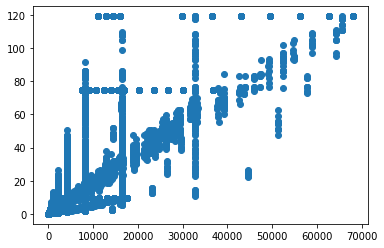

In [6]:
plt.scatter(samples.I_4,1/samples.W_100)

<AxesSubplot:>

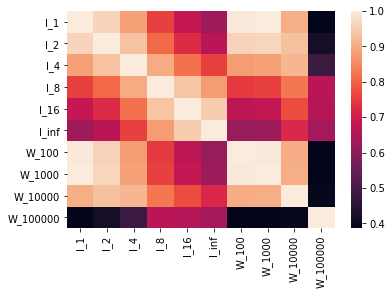

In [7]:
sns.heatmap(pd.concat((samples.iloc[:,:6],1/samples.iloc[:,6:10]),axis=1).corr())

W_100000 quite different at the data sizes we are working with, because of the level of inf observations

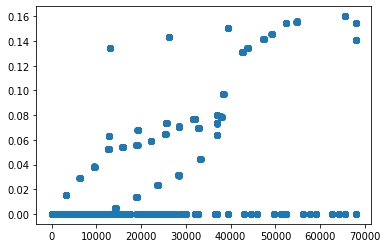

In [8]:
plt.scatter(samples.I_4,1/samples.W_100000)

In [213]:
I=samples_long[samples_long.metric.str.startswith('I')].groupby(['location','metric','size'], as_index=False).error.agg(lambda x: (np.sum(x**2)/len(x))**0.5)

In [243]:
a=[]
for _,g in I.groupby(['location','metric']):
    # b=interpolate.UnivariateSpline(g['size'], g['error'],k=3,s=2000)
    t=np.exp(np.log(np.ma.masked_invalid(g['size'].values)).mean())
    b=interpolate.LSQUnivariateSpline(g['size'], g['error'],k=3,t=[10,100,1000])
    new_error=b(g['size'],nu=0)
    a.extend(new_error)
I['smooth']=a

/var/folders/kr/9rjggpcj2qx4ndk46ffx_t8w0000gn/T/ipykernel_3063/3634099367.py:4: RuntimeWarning: divide by zero encountered in log
  t=np.exp(np.log(np.ma.masked_invalid(g['size'].values)).mean())


In [245]:
df=[]
for _,g in samples_long[samples_long.metric.str.startswith('I')].groupby(['location','metric']):
    a = g.sort_values('size')
    # o=sm.nonparametric.lowess(g['error'].values,np.log(np.maximum(g['size'].values,0.5)),frac=0.25)
    o=sm.nonparametric.lowess(a['error'].values,a['size'].values,frac=0.25)
    # print(g['size'].values-o[:,0])
    _,idx=np.unique(a['size'].values,return_index=True)
    # _,idx2=np.unique(o[:,0],return_index=True) #to ensure np.nan treated as unique
    # print(len(idx))
    df.extend(o[idx,1])
I['lowess']=np.array(df)

In [247]:
I_long=I.melt(id_vars=['location','metric','size'],value_vars=['smooth','lowess'],var_name="smoother",value_name="smoothed_error")
I_long

location metric      size smoother  smoothed_error
0      goodchild    I_1       0.0   smooth      238.274148
1      goodchild    I_1       1.0   smooth      199.209383
2      goodchild    I_1       2.0   smooth      167.440925
3      goodchild    I_1       3.0   smooth      142.163555
4      goodchild    I_1       4.0   smooth      122.572055
...          ...    ...       ...      ...             ...
30955        ucl  I_inf  116296.0   lowess        2.236506
30956        ucl  I_inf  119322.0   lowess        2.225194
30957        ucl  I_inf  127785.0   lowess        2.193491
30958        ucl  I_inf  129403.0   lowess        2.187424
30959        ucl  I_inf  131072.0   lowess        2.181165

[30960 rows x 5 columns]

(0.0, 20.0)

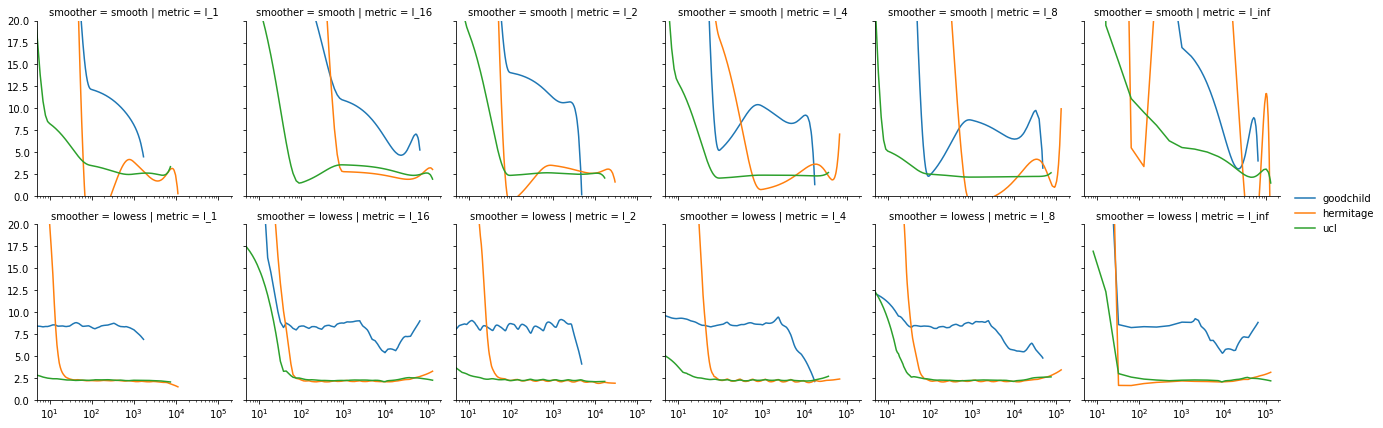

In [248]:
g=sns.FacetGrid(I_long,col='metric',row='smoother')
g.map_dataframe(sns.lineplot,x='size',y='smoothed_error',hue='location',legend='full')
g.add_legend()
plt.xscale('log')
plt.ylim(0,20)

In [258]:
W_=samples_long[samples_long.metric.str.startswith('W')].copy()
W_['size']=1/W_['size']
W=W_.groupby(['location','metric','size'], as_index=False).error.agg(lambda x: (np.sum(x**2)/len(x))**0.5)

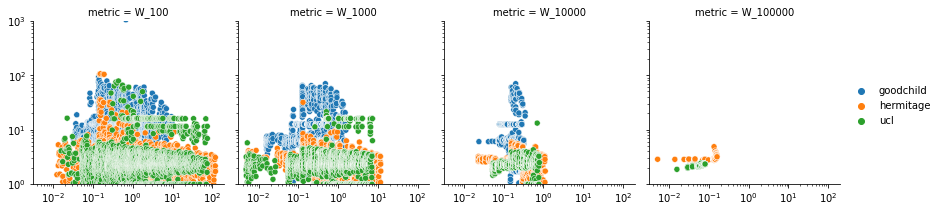

In [259]:
g=sns.FacetGrid(W,col='metric')
g.map_dataframe(sns.scatterplot,x='size',y='error',hue='location',legend='full')
g.add_legend()
plt.xscale('log')
plt.ylim(1,1000)
plt.yscale('log')

In [284]:
W[['metric','location','size']].value_counts().count()

22639

In [280]:
W

location    metric      size       error
0      goodchild     W_100  0.000000  223.757786
1      goodchild     W_100  0.031602    0.375452
2      goodchild     W_100  0.031963    0.072381
3      goodchild     W_100  0.032256    6.696547
4      goodchild     W_100  0.032462    5.756516
...          ...       ...       ...         ...
22634        ucl  W_100000  0.079899    2.310309
22635        ucl  W_100000  0.079901    2.308774
22636        ucl  W_100000  0.079951    2.315773
22637        ucl  W_100000  0.080017    2.312879
22638        ucl  W_100000  0.080065    2.329780

[22639 rows x 4 columns]

Dropping 

In [311]:
df=[]
for _,g in W.groupby(['location','metric']):
    a=g.sort_values('size')
    # b=interpolate.UnivariateSpline(a['size'], a['error'],k=3,s=100000)
    t=np.ma.masked_invalid(a['size'].values).mean()
    try:
        b=interpolate.LSQUnivariateSpline(a['size'], a['error'],k=3,t=[t])
        new_error=b(a['size'],nu=0)
        df.extend(new_error)
    except:
        df.extend(
            np.ones_like(a['size'].values) *
            np.ma.masked_invalid(a['error'].values).mean()
            )
W['smooth']=df

In [316]:
df=[]
for _,g in W_.groupby(['location','metric']):
    a = g.sort_values('size')
    # o=sm.nonparametric.lowess(g['error'].values,np.log(np.maximum(g['size'].values,0.5)),frac=0.25)
    o=sm.nonparametric.lowess(a['error'].values,a['size'].values,frac=0.5)
    _,idx=np.unique(a['size'].values,return_index=True)
    # _,idx2=np.unique(o[:,0],return_index=True) #to ensure np.nan treated as unique
    df.extend(o[idx,1])
W['lowess']=np.array(df)

/Users/terrylines/Documents/GNSS/gnssmapper/.venv/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:214: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


In [317]:
W

location    metric      size       error    lowess    smooth
0      goodchild     W_100  0.000000  223.757786  8.951670  6.977102
1      goodchild     W_100  0.031602    0.375452  8.771689  7.990620
2      goodchild     W_100  0.031963    0.072381  8.769652  8.001758
3      goodchild     W_100  0.032256    6.696547  8.768000  8.010783
4      goodchild     W_100  0.032462    5.756516  8.766836  8.017136
...          ...       ...       ...         ...       ...       ...
22634        ucl  W_100000  0.079899    2.310309       NaN  2.639797
22635        ucl  W_100000  0.079901    2.308774       NaN  2.640362
22636        ucl  W_100000  0.079951    2.315773       NaN  2.651640
22637        ucl  W_100000  0.080017    2.312879       NaN  2.666658
22638        ucl  W_100000  0.080065    2.329780       NaN  2.677848

[22639 rows x 6 columns]

In [318]:
W_long=W.melt(id_vars=['location','metric','size'],value_vars=['smooth','lowess'],var_name="smoother",value_name="smoothed_error")
W_long

location    metric      size smoother  smoothed_error
0      goodchild     W_100  0.000000   smooth        6.977102
1      goodchild     W_100  0.031602   smooth        7.990620
2      goodchild     W_100  0.031963   smooth        8.001758
3      goodchild     W_100  0.032256   smooth        8.010783
4      goodchild     W_100  0.032462   smooth        8.017136
...          ...       ...       ...      ...             ...
45273        ucl  W_100000  0.079899   lowess             NaN
45274        ucl  W_100000  0.079901   lowess             NaN
45275        ucl  W_100000  0.079951   lowess             NaN
45276        ucl  W_100000  0.080017   lowess             NaN
45277        ucl  W_100000  0.080065   lowess             NaN

[45278 rows x 5 columns]

(0.0, 20.0)

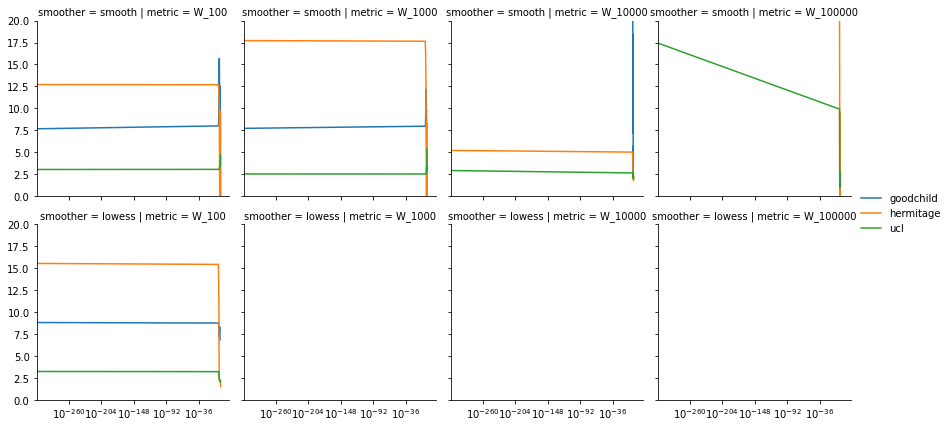

In [319]:
g=sns.FacetGrid(W_long,col='metric',row='smoother')
g.map_dataframe(sns.lineplot,x='size',y='smoothed_error',hue='location',legend='full')
g.add_legend()
plt.xscale('log')
plt.ylim(0,20)